# Multiple Runs Analysis

Notebook to test functions for mutiple runs simultaneously.

In [1]:
import nbimporter
import prepData as prep
import fitFunc as fits
import Statistics as stat

import matplotlib.pyplot as plt
import numpy as np 
import math

## Multiple Runs fit

In [ ]:
x0 = 1.0353e+10+410000

In [ ]:
runsData = prep.Load()

In [ ]:
mins=np.empty(len(runsData))
maxs=np.empty(len(runsData))

for i_run,run in enumerate(runsData):
    mins[i_run]=min(run["freq"])
    maxs[i_run]=max(run["freq"])
    
    plt.plot(run["freq"],run["fft"])
    print(mins[i_run],maxs[i_run])

In [ ]:
np.min(mins),np.max(maxs)

In [ ]:
fitBkg = fits.multipleFitBKG(runsData)

In [ ]:
fitSig = fits.multipleFitSIG(runsData, fitBkg, x_0=x0)

## Confidence interval

In [2]:
def multiple_calc_qmu(toyData, x0,mu_fix):
    
    n_toy = len(toyData)
    
    # compute likelihood ratio for toy dataset
    q_mu = np.empty(n_toy)
    for i_toy,toy in enumerate(toyData):
        
        toy_bkg_params = fits.multipleFitBKG(toy)
        
        fix_toy=fits.multipleFitSIG(toy, toy_bkg_params, x_0=x0,mu_init=mu_fix,mu_vary=False)
        fitSig_toy=fits.multipleFitSIG(toy, toy_bkg_params, x_0=x0)
        
        q_mu[i_toy] = stat.multiple_lh_ratio(toy, "fft",fix_toy, "sig_bestFit",fitSig_toy,"sig_bestFit")
        
    return q_mu

In [3]:
def multipleCI(InfoDataset, fitBkg, fitSig,toy_0,x_0, mu_fix,verbose=False,draw=False):
    
    n_toy = len(toy_0)
    
    # scan for mu
    q_mu_obs_prev = 0            # save distribution and parameters
    q_mu_prev = np.empty(n_toy)  # to plot optimal result
    q0_prev = np.empty(n_toy)
    
    r_prev = 1e10
    mu_95 = 0
    
    sign_prev = 0
        
    mu_test=mu_fix
    cross_check=0
    
    all_mu=[mu_fix]
    while True:
        
        fix = fits.multipleFitSIG(InfoDataset, fitBkg, x_0=x_0,mu_init=mu_test,mu_vary=False)
        
        # compute likelihood ratio of observed data
        q_mu_obs = stat.multiple_lh_ratio(InfoDataset, "fft",
                                       fix, "sig_bestFit",
                                       fitSig, "sig_bestFit")
        
        if(verbose):
            print("Mu: ", mu_test, "   q(mu)_obs =", q_mu_obs)
        
        # generate toy datasets from fixed mu
        toy_fix = stat.multiple_toydataset(fix, n=n_toy, data_type="sig_bestFit")
        
        q_mu=multiple_calc_qmu(toy_fix,x_0,mu_test)
        q0=multiple_calc_qmu(toy_0,x_0,mu_test)
        
        # compute p-values
        p_mu = stat.p_value(q_mu_obs, q_mu)
        p_b  = stat.p_value(q_mu_obs, q0)
        
        # compute ratio
        r = p_mu/p_b
            
        if(verbose):
            print("p_mu =", p_mu, "  p_b =", p_b, "  ratio =", r, "\n")
            
        # check results to proceed with the mu scan:
        # if the ratio is close eneough to target we save the results and stop
        # else we check if we are under- or overshooting and correct the estimate
        # if we cross the target we stop and take the best result between
        # current and previous step
        
        if math.isnan(r):
            break
            
        reached_target, crossed_target, is_current_worse = False, False, False
        
        reached_target = (np.abs(r - 0.05) <= 0.01)
        if not reached_target:
            sign = np.sign(r - 0.05)
            crossed_target = (sign*sign_prev == -1)
            
            if crossed_target:
                is_current_worse = (np.abs(r - 0.05) > np.abs(r_prev - 0.05))
                cross_check+=1
        
        # update best estimate for every case except the last
        if not is_current_worse:
            q_mu_obs_prev = q_mu_obs            
            q_mu_prev = q_mu  
            q0_prev = q0
            mu_95 = mu_test
            
        if reached_target or cross_check==3:
            cross_check=0
            break
        
        #adaptive step algorithm
        step=0   
        check=r-0.05
        
        if np.abs(check) > 0.5:
            step = sign*2
        elif ((np.abs(check) > 0.2) and (np.abs(check) < 0.5)):
            step = sign*7/5
        elif ((np.abs(check) > 0.08) and (np.abs(check) < 0.2)):
            step = sign
        else:
            step = sign*2/5
            
        # update mu if we did not exit the loop
        mu_test = mu_test + step*5
        r_prev = r
        sign_prev = sign
        
        #check if the next mu has been already tested
        if mu_test in all_mu:
            break
        else:
            all_mu.append(mu_test)
            
        if mu_test <= 0:
            mu_test=1
            
    # plot significance distribution
    if(draw):
        stat.plot_lhratio(q_mu_obs_prev, q0_prev, q_mu_prev, x_0, mu_95)
            
    return(mu_95)

In [4]:
def stat_test(InfoDataset,x_0,mu_fix=1.0,nToy=1000,verbose=False,draw=False):
    
    #fit background once
    fitBkg = fits.multipleFitBKG(InfoDataset)
    
    # generate toy datasets from bkg and fit them
    toy_0 = stat.multiple_toydataset(fitBkg, n=nToy, data_type="bkg_bestFit")
    
    mu_CI = np.empty(len(x_0))
    for i_x0,x0 in enumerate(x_0):
        
        print("Testing x0:",x0)
        fitSig = fits.multipleFitSIG(InfoDataset, fitBkg, x_0=x0)
        
        if i_x0 == 0:
            mu_CI[i_x0] = multipleCI(InfoDataset,fitBkg,fitSig,toy_0,x0,mu_fix,verbose,draw)
        
        else:
            mu_CI[i_x0] = multipleCI(InfoDataset,fitBkg,fitSig,toy_0,x0,mu_CI[i_x0-1],verbose,draw)
        
        print("mu_CI:",mu_CI[i_x0])
        print("---------------------")
    
    return mu_CI    

### Test

In [20]:
all_freq=np.linspace(10353286068+16*651, 10353286068+31*16*651,30)
runsData = prep.Load()

#### Range(0,5)

In [24]:
x0_1=all_freq[range(0,5)]
print(x0_1)

[1.03532965e+10 1.03533073e+10 1.03533180e+10 1.03533288e+10
 1.03533396e+10]


Testing x0: 10353296484.0
Mu:  10    q(mu)_obs = 12.560410596284783
p_mu = 0.001   p_b = 0.036   ratio = 0.02777777777777778 

Mu:  8.0    q(mu)_obs = 8.893684146594751
p_mu = 0.003   p_b = 0.036   ratio = 0.08333333333333334 



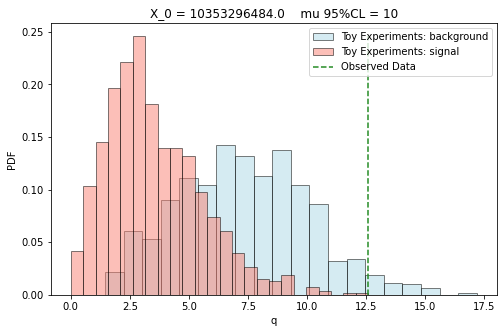

mu_CI: 10.0
---------------------
Testing x0: 10353307259.172413
Mu:  10.0    q(mu)_obs = 5.96060477694482
p_mu = 0.628   p_b = 0.969   ratio = 0.6480908152734778 

Mu:  20.0    q(mu)_obs = 34.12053330912022
p_mu = 0.099   p_b = 0.969   ratio = 0.10216718266253871 

Mu:  22.0    q(mu)_obs = 42.52415587215364
p_mu = 0.056   p_b = 0.969   ratio = 0.057791537667698664 



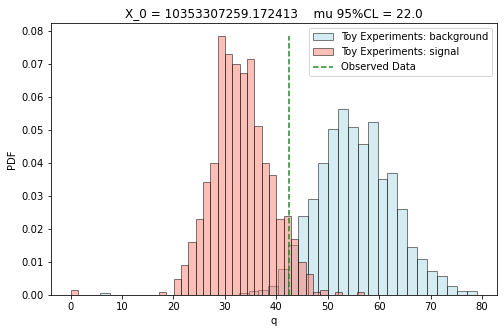

mu_CI: 22.0
---------------------
Testing x0: 10353318034.344828
Mu:  22.0    q(mu)_obs = 38.68983464118355
p_mu = 0.164   p_b = 0.999   ratio = 0.16416416416416418 

Mu:  27.0    q(mu)_obs = 65.7879467789353
p_mu = 0.02   p_b = 0.998   ratio = 0.02004008016032064 

Mu:  25.0    q(mu)_obs = 54.0913768432365
p_mu = 0.067   p_b = 0.999   ratio = 0.06706706706706707 



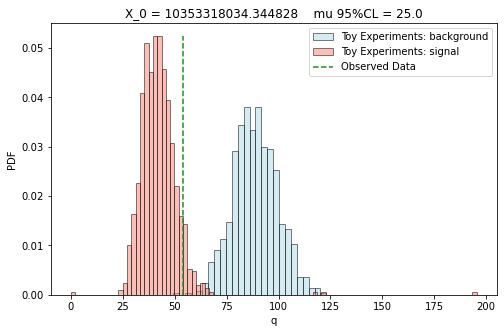

mu_CI: 25.0
---------------------
Testing x0: 10353328809.51724
Mu:  25.0    q(mu)_obs = 77.73871927184518
p_mu = 0.011   p_b = 1.0   ratio = 0.011 

Mu:  23.0    q(mu)_obs = 63.27341765995516
p_mu = 0.031   p_b = 1.0   ratio = 0.031 

Mu:  21.0    q(mu)_obs = 50.294740587021806
p_mu = 0.063   p_b = 1.0   ratio = 0.063 



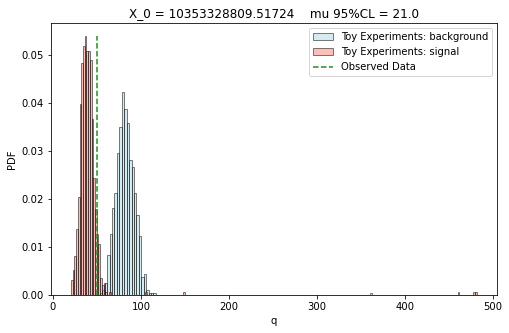

mu_CI: 21.0
---------------------
Testing x0: 10353339584.689655
Mu:  21.0    q(mu)_obs = 86.3118500747114
p_mu = 0.003   p_b = 0.849   ratio = 0.0035335689045936395 

Mu:  19.0    q(mu)_obs = 69.81251225701635
p_mu = 0.007   p_b = 0.849   ratio = 0.008244994110718492 

Mu:  17.0    q(mu)_obs = 55.06040599604603
p_mu = 0.006   p_b = 0.849   ratio = 0.007067137809187279 

Mu:  15.0    q(mu)_obs = 42.05602294242999
p_mu = 0.021   p_b = 0.849   ratio = 0.02473498233215548 

Mu:  13.0    q(mu)_obs = 30.79985489290266
p_mu = 0.054   p_b = 0.849   ratio = 0.06360424028268552 



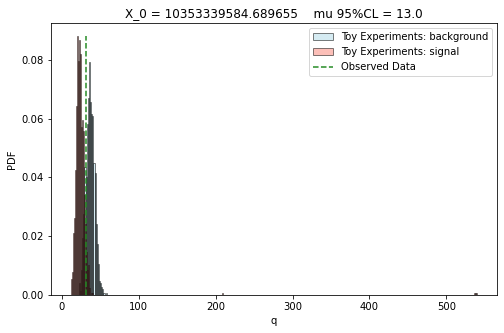

mu_CI: 13.0
---------------------


In [6]:
muCL1=stat_test(runsData,x0_1,mu_fix=10,verbose=True,draw=True)

In [23]:
muCL1

array([10., 22., 25., 21., 13.])

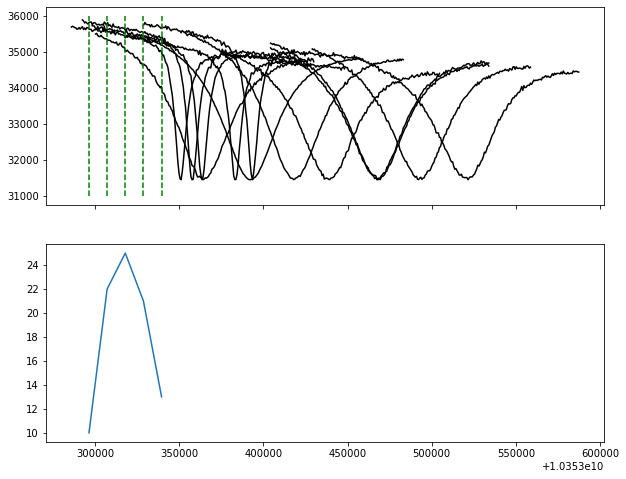

In [18]:
fig,ax=plt.subplots(2,1,figsize=(10,8),sharex=True)

for run in runsData:
    ax[0].plot(run["freq"],run["fft"],color="black")

for x_0 in x0:
    ax[0].vlines(x0_1,31000,36000,color="green",linestyle="dashed")
    
ax[1].plot(x0_1,muCL1)

#### Range(5,10)

In [25]:
x0_2=all_freq[range(5,10)]
print(x0_2)

[1.03533504e+10 1.03533611e+10 1.03533719e+10 1.03533827e+10
 1.03533935e+10]


In [ ]:
muCL2=stat_test(runsData,x0_2,mu_fix=13,verbose=True,draw=True)

In [ ]:
muCL2

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(10,8),sharex=True)

for run in runsData:
    ax[0].plot(run["freq"],run["fft"],color="black")

for x_0 in x0:
    ax[0].vlines(x0_2,31000,36000,color="green",linestyle="dashed")
    
ax[1].plot(x0_2,muC2)

#### Range(10,15)

In [ ]:
x0_3=all_freq[range(10,15)]
print(x0_3)

#It is necessary to find the appropriate initial mu
mu_fix3 = 

In [ ]:
muCL3=stat_test(runsData,x0_3,mu_fix=mu_fix3,verbose=True,draw=True)

#### Range(15,20)

In [ ]:
x0_4=all_freq[range(15,20)]
print(x0_4)

#It is necessary to find the appropriate initial mu
mu_fix4 = 

In [ ]:
muCL4=stat_test(runsData,x0_4,mu_fix=mu_fix4,verbose=True,draw=True)

#### Range(20,25)

In [ ]:
x0_5=all_freq[range(20,25)]
print(x0_5)

#It is necessary to find the appropriate initial mu
mu_fix5 = 

In [ ]:
muCL5=stat_test(runsData,x0_5,mu_fix=mu_fix5,verbose=True,draw=True)

#### Range(25,30)

In [ ]:
x0_6=all_freq[range(25,30)]
print(x0_6)

#It is necessary to find the appropriate initial mu
mu_fix6 = 

In [ ]:
muCL6=stat_test(runsData,x0_6,mu_fix=mu_fix6,verbose=True,draw=True)